In [1]:
from multiinstance.utils import *

import numpy as np

from dist_curve.curve_constructor import makeCurve

import scipy.stats as ss

import matplotlib.pyplot as plt

In [40]:
from easydict import EasyDict

In [69]:
def getBagPositive(weights=None, size_lam=25):
    # Positive
    if weights is None:
        weights = np.random.dirichlet((1,1))
    size= np.random.poisson(size_lam)
    p = np.concatenate((np.random.normal(loc=-3,size=int(weights[0] * size)),
                        np.random.normal(loc=3,size=int(weights[1] * size))))
    assignments = np.zeros(size)
    assignments[int(weights[0] * size):] = 1
    return p,assignments, weights

def getBag():
    d = EasyDict()
    d.pos, d.pos_component_assignments, d.gamma_1 = getBagPositive(size_lam=10)
    d.alpha = np.random.uniform()
    unlabeledPos, d.uPos_comp_assign, _ = getBagPositive(weights=d.gamma_1, size_lam=int(100 * d.alpha))
    d.gamma_0 = np.random.dirichlet((1,))
    unlabeledNeg = np.random.normal(size=int(d.gamma_0[0] * 100 * (1-d.alpha)))
    d.unlabeled = np.concatenate((unlabeledPos, unlabeledNeg))
    return d
    

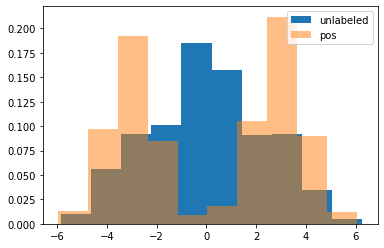

In [56]:
bags = [getBag() for _ in range(100)]
plt.hist(np.concatenate([d.unlabeled for d in bags]), label="unlabeled",alpha=1,density=True)
plt.hist(np.concatenate([d.pos for d in bags]),label="pos",density=True,alpha=.5)
plt.legend()

## bag$_i$
$ f_1^i(x)= \sum_{j\in j_1}r_j^i \phi_j^1(x) $

$ f^i(x) = \alpha_i \sum_{j\in j_1} r_j^i \phi_j^1(x) + (1 - \alpha_i)\sum_{j\in j_0} \gamma_j^0 \phi_j^0(x)$

## Merged bags

$w_i = \frac{|c_i|}{\sum_j |c_j|} $

$ w_i^0 = \frac{|m_i|}{\sum_j |m_j|} $

$ f_1(x) = \sum_{j \in j_1} (\sum_{i \in b_i} w_i^1r_j^i) \phi^1_j(x)$

$ f(x) = \sum_{j \in j_1}[(\sum_{i \in b_i} w^0_i \alpha_ir_j^i) \phi_j^1(x)]  + \sum_{j \in j_0}[\sum_{i\in b_i}w^0_i(1 - \alpha_i))\gamma_j^0\phi_j^0(x)]$ 

In [200]:
def mergeBags(bags):
    "Calculate the mixing coefficients of the positive and unlabeled distributions of the merged bags"
    # calculate bag weights based on pos/ unlabeled sizes
    w1 = np.array([d.pos.shape[0] for d in bags])
    w0 = np.array([d.unlabeled.shape[0] for d in bags])
    w1 = w1 / w1.sum()
    w0 = w0 / w0.sum()
    # calculate positive component weights
    gamma_1s = np.concatenate([d.gamma_1.reshape((1,-1)) for d in bags],axis=0)
    g1 = np.multiply(gamma_1s.T,w1).T.sum(0)
    # unlabeled positive components weights
    alpha_i = np.array([d.alpha for d in bags])
    wa = np.multiply(w0,alpha_i)
    gamma_0s = np.concatenate([d.gamma_0.reshape((1,-1)) for d in bags],axis=0)
    gUnlabeled1 = np.multiply(gamma_1s.T,wa).T.sum(0)
    # unlabeled negative components weights
    wa1 = np.multiply(w0,1 - alpha_i).reshape((-1,1))
    gUnlabeled0 = np.multiply(gamma_0s, wa1).sum()
    # get results
    d = EasyDict()
    d.g1 = g1
    d.gUnlabeled1 = gUnlabeled1
    d.gUnlabeled0 = gUnlabeled0
    # Ensure positive and unlabeled component weights form valid simplex
    assert np.allclose(g1.sum(), np.ones(1))
    assert np.allclose(gUnlabeled0.sum() + gUnlabeled1.sum(),np.ones(1))
    return d

In [198]:
bags = [getBag()]

mergeBags(bags)

{'g1': array([0.3788221, 0.6211779]),
 'gUnlabeled1': array([0.14711823, 0.24123882]),
 'gUnlabeled0': 0.6116429534501413}